##### Set up packages and directories

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
import copy
from joblib import Parallel, delayed

In [2]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"
cryptic_input_path = "D:/Project_Data/CRYPTIC_DATA/"
output_dir = project_dir + '/Output'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Downstream_Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
extended_non_cds_regions_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_Non_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis'
num_cores = 16

##### Translation function

In [3]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]

In [61]:
def translate_sequence(input_seq, strand, rf):
    output_seq = ''
    if strand == 1:
        seq = input_seq[rf:]
    else:
        seq = align.reverse_complement(input_seq)[rf:]
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

##### Mycobrowser is used for CDS demarcation, sequence is taken from GCF_000195955.2

In [5]:
genome_record = next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank"))
full_sequence = genome_record.seq
actual_cds_boundaries = []
mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
temp = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand']]
actual_cds_boundaries = []
for i, r in temp.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    actual_cds_boundaries.append((r['Locus'],r['Start']-1, r['Stop'], strand))

##### Load variant dataset and create variant dictionary (0 indexed for genome position - whereas CRyPtiC data uses 1 start)

In [35]:
variant_count_df = pd.read_csv(cryptic_output_path + '/filtered_variant_summary_df.csv')
variant_count_df = variant_count_df[variant_count_df['MUTATION_PCT'] < 0.1]

In [20]:
temp = variant_count_df.groupby(['GENOME_INDEX'])[['MYKROBE_LINEAGE_NAME_2']].count().reset_index()
temp_dict = dict(zip(temp.GENOME_INDEX, temp.MYKROBE_LINEAGE_NAME_2))

In [21]:
mutation_counts_dict = {}
for i in tqdm(range(len(full_sequence))):
    if (i+1) in temp_dict:
        mutation_counts_dict[i] = temp_dict[(i+1)]
    else:
        mutation_counts_dict[i] = 0

  0%|          | 0/4411532 [00:00<?, ?it/s]

##### Define binomial probabilities for testing mutation counts

In [10]:
def bin_formula(max_bin_counts, tot_bin_counts, in_frame = False):
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

In [11]:
def mutation_bin_probability(start, end, strand):
    mutations = []
    for i in range(start,end):
        for j in range(mutation_counts_dict[i]):
            mutations.append(i)
    bin_counts = [0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (2, sum(bin_counts), bin_counts)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)), sum(bin_counts), bin_counts)  

##### Function to find maximal open reading frame between two co-ordinates with mutation probability less than 0.001

In [12]:
def max_orf(seq_start, seq_stop, p_value):
    max_len = 0
   
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (full_sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(full_sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for i in range(seq_len - 2):
            orf_length = 0
            test_codon = temp[i: i+3] 
            if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
                for j in range(i + 3, seq_len - 2, 3):
                    test_codon_2 = temp[j: j+3] 
                    if test_codon_2 in ['TAG','TGA','TAA']:
                        orf_length = j - i
                        break
                if orf_length > max_len and ((frame == 'Forward' and mutation_bin_probability(seq_start+i, seq_start+j+3, 1)[0]< p_value)
                                             or (frame == 'Reverse' and mutation_bin_probability(seq_start+seq_len-(j+3), seq_start+seq_len-i, -1)[0]<p_value)):
                    max_len = orf_length
                    if frame == 'Forward':
                        strand = 1
                        start_pos = i
                        end_pos = j+3
                        
                    else:
                        strand = -1
                        start_pos = seq_len-(j+3)
                        end_pos = seq_len-i
    if start_pos == -999:
        return(0,0,0)
    else:
        return(seq_start+start_pos, seq_start+end_pos, strand)   

##### Graph p-values for annotated genes

In [13]:
annotated_cds_probabilities = []
for (locus, start, stop, strand) in tqdm(actual_cds_boundaries):
    annotated_cds_probabilities.append((locus, mutation_bin_probability(start, stop, strand)))

  0%|          | 0/4031 [00:00<?, ?it/s]

Text(0, 0.5, 'number of genes - Mycobrowser R3 annotation')

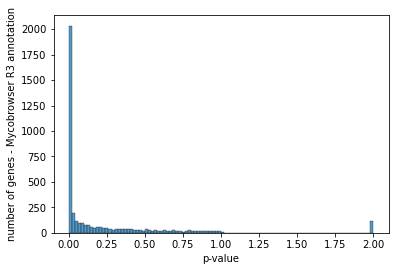

In [14]:
annotation_probs = [x[1][0] for x in annotated_cds_probabilities]
sns.histplot(annotation_probs, bins = 100)
plt.xlabel("p-value")
plt.ylabel("number of genes - Mycobrowser R3 annotation") 

##### Identify function percentage in Unknown between high and low p-value regions

In [ ]:
locus_info_dict = {}
for i, r in mycobrowser_df.iterrows():
    if r['Feature'] == 'CDS':
        locus_info_dict[r['Locus']] = r['Function']

In [ ]:
locus_exceptions = [x[0] for x in annotated_cds_probabilities if (x[1][0] > 0.5 and x[1][0] < 1.1)]
num_unknown_exceptions = 0
for ex in locus_exceptions:
    if 'nknown' in locus_info_dict[ex]:
        num_unknown_exceptions += 1
tot_locus = [x[0] for x in annotated_cds_probabilities]
num_unknown_tot = 0
for ex in tot_locus:
    if len(str(locus_info_dict[ex])) > 4:
        if 'nknown' in locus_info_dict[ex]:
            num_unknown_tot += 1
print(num_unknown_exceptions, len(locus_exceptions))
print(num_unknown_tot, len(tot_locus))
print(num_unknown_exceptions/len(locus_exceptions), (num_unknown_tot-num_unknown_exceptions)/(len(tot_locus)-len(locus_exceptions)))

##### Percentage of nt mutated by each CDS

<AxesSubplot:ylabel='Count'>

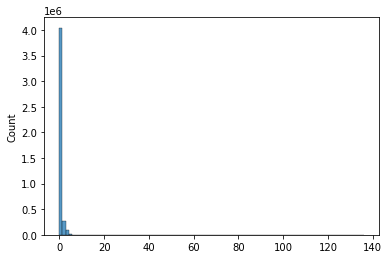

In [27]:
num_mutations = []
for k, v in mutation_counts_dict.items():
    num_mutations.append(v)
sns.histplot(num_mutations, bins=100)

  0%|          | 0/4031 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Pct_Mutation', ylabel='Count'>

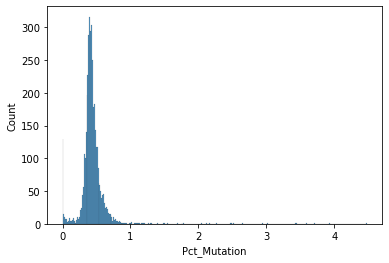

In [22]:
cds_mutation_percentage = []
for (locus, start, stop, strand) in tqdm(actual_cds_boundaries):
    num_mutations = 0
    for i in range(start,stop):
        num_mutations += (mutation_counts_dict[i])
    cds_mutation_percentage.append([locus, num_mutations / (stop - start)])
temp = pd.DataFrame(cds_mutation_percentage)
temp.columns = ['Locus', 'Pct_Mutation']
sns.histplot(temp['Pct_Mutation'])

In [ ]:
##### Now start off with lower than 0.5 p-values in set and add maximal ORF sets with p-values < 0.1

In [ ]:
p_value = 0.1
num_iterations = 0
cds_boundaries = [[0, 0], [4411530, 4411530]]      #De novo
cds_dict = {}
for i in cds_boundaries:
    cds_dict[tuple(i)] = 1
    
    
#cds_boundaries = []
#cds_dict = {}
#for (locus, x, y, strand) in actual_cds_boundaries:
#    if mutation_bin_probability(x, y, strand)[0] <= 0.2:
#        cds_dict[(x,y)] = strand
#        cds_boundaries.append([x, y])
    
exhausted_cds = []
while len(exhausted_cds) < len(cds_boundaries) - 1:
    temp_boundaries = []
    for i, (x,y) in enumerate((cds_boundaries)):
        if i < len(cds_boundaries) - 1:
            if [x,y] in exhausted_cds:
                pass
            else:
                temp = cds_boundaries[i+1][0]
                res = max_orf(y, temp, p_value)
                if res[0] == 22074 and res[1] == 22176:
                    print((y, temp))
                if (res[1] - res[0] < 100):
                    exhausted_cds.append([x,y])
                else:
                    temp_boundaries.append([res[0], res[1]])
                    cds_dict[(res[0],res[1])] = res[2]
                
    cds_boundaries = sorted(cds_boundaries + temp_boundaries, key=lambda x: x[0])
    print("iteration " + str(num_iterations) + ":  "+str(len(cds_boundaries))+ " found.  "+str(len(exhausted_cds))+" exhausted regions")
    num_iterations += 1

In [ ]:
def max_overlap(boundary, comparison_boundaries):
    max_overlap = 0
    comparison_boundary_0 = 0
    comparison_boundary_1 = 0
    locus = ''
    strand = 1
    for bound in comparison_boundaries:
        overlap = min(boundary[1], bound[2]) - max(boundary[0], bound[1])
        if overlap > max_overlap:
            max_overlap = overlap
            comparison_boundary_0 = bound[1]
            comparison_boundary_1 = bound[2]
            locus = bound[0]
            strand = bound[3]
    return(locus, strand, comparison_boundary_0, comparison_boundary_1, max_overlap)

In [ ]:
temp = []
for bound in tqdm(cds_boundaries):
    a = max_overlap(bound, actual_cds_boundaries)
    if a[3] > 0:
        temp.append([a[0],a[1],a[2],a[3],a[4], cds_dict[(bound[0],bound[1])], bound[0], bound[1], bound[0]-a[2], bound[1]-a[3]])
df = pd.DataFrame(temp, columns = ['locus','annotation_strand','annotation_start','annotation_end', 'overlap', 'simulated_strand','simulated_start', 'simulated_end', 'start_offset','end_offset'])

######  Run local alignments of alternative translated CDS against target in all reading frames

In [167]:
tb_seq = str(next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank")).seq)
target_seq = str(next(SeqIO.parse(genome_datasets_dir + '/GCF_016745295.1/genomic.gbff', "genbank")).seq)

In [172]:
target_sequences = []
for i in tqdm(range(3)):
    for j in [1, -1]:
        target_sequences.append(translate_sequence(target_seq, j, i).replace('*','Z'))

  0%|          | 0/3 [00:00<?, ?it/s]

In [173]:
aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 5
aligner.mismatch_score = -9
aligner.target_internal_open_gap_score = -3
aligner.target_internal_extend_gap_score = -1
aligner.target_end_open_gap_score = -1
aligner.target_end_extend_gap_score = -1
aligner.query_internal_open_gap_score = -3
aligner.query_internal_extend_gap_score = -1

# Set the query_end penalties to zero to effectively implement a 'glocal' alignment as described in the question
# These are the default values, so you could skip the next two lines, 
#    but this is relevant to the question, so I'm including them in the example.
aligner.query_end_open_gap_score = 0
aligner.query_end_extend_gap_score = 0

query_seq = translate_sequence(tb_seq[13132:13558],-1,0).replace('*','Z')
for target in tqdm(target_sequences):
    alignments = aligner.align(target, query_seq)
    print(alignments.score/len(query_seq))
    print(alignments[0].aligned)

  0%|          | 0/6 [00:00<?, ?it/s]

0.39436619718309857
(((837319, 837320), (837320, 837322), (837322, 837323), (837329, 837331), (837333, 837334), (837334, 837335), (837340, 837341), (837341, 837343), (837343, 837346), (837346, 837348), (837349, 837350), (837355, 837356), (837356, 837358), (837359, 837362), (837363, 837364), (837367, 837368), (837369, 837370), (837371, 837372), (837372, 837374), (837374, 837376), (837376, 837377), (837377, 837380), (837380, 837381), (837381, 837382), (837383, 837384), (837384, 837385), (837385, 837388), (837389, 837390), (837391, 837392), (837398, 837399), (837399, 837400), (837404, 837405), (837407, 837408), (837412, 837413), (837416, 837417), (837418, 837419), (837420, 837421), (837423, 837424), (837424, 837427), (837427, 837428)), ((6, 7), (13, 15), (16, 17), (17, 19), (19, 20), (24, 25), (25, 26), (34, 36), (38, 41), (42, 44), (44, 45), (45, 46), (52, 54), (54, 57), (57, 58), (58, 59), (59, 60), (61, 62), (66, 68), (70, 72), (76, 77), (78, 81), (93, 94), (95, 96), (101, 102), (105, 

In [132]:
print(alignments[0].aligned)

(((1592307, 1592308), (1592308, 1592309), (1592311, 1592312), (1592312, 1592313), (1592313, 1592314), (1592314, 1592316), (1592320, 1592322), (1592322, 1592324), (1592327, 1592328), (1592328, 1592329), (1592329, 1592330), (1592330, 1592332), (1592335, 1592336), (1592336, 1592337), (1592337, 1592339), (1592340, 1592341), (1592341, 1592342), (1592345, 1592349), (1592353, 1592354), (1592363, 1592364), (1592366, 1592367), (1592367, 1592368), (1592368, 1592370), (1592371, 1592372), (1592372, 1592374), (1592374, 1592377), (1592384, 1592386), (1592391, 1592395), (1592396, 1592397), (1592400, 1592401), (1592401, 1592402), (1592403, 1592405), (1592405, 1592406), (1592406, 1592407), (1592408, 1592409), (1592412, 1592414), (1592414, 1592415), (1592416, 1592417), (1592418, 1592419), (1592419, 1592420), (1592424, 1592425), (1592426, 1592427), (1592427, 1592428), (1592430, 1592431), (1592431, 1592432), (1592432, 1592434), (1592434, 1592436), (1592440, 1592441), (1592441, 1592443), (1592450, 1592451)

In [90]:
print(actual_cds_boundaries[0:10])

[('Rv0001', 0, 1524, 1), ('Rv0002', 2051, 3260, 1), ('Rv0003', 3279, 4437, 1), ('Rv0004', 4433, 4997, 1), ('Rv0005', 5239, 7267, 1), ('Rv0006', 7301, 9818, 1), ('Rv0007', 9913, 10828, 1), ('Rv0008c', 11873, 12311, -1), ('Rv0009', 12467, 13016, 1), ('Rv0010c', 13132, 13558, -1)]


In [134]:
orthologs = sar.Ortholog_Grouping(ortholog_dir)

100%|██████████| 75075/75075 [00:03<00:00, 22904.21it/s]


In [136]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, 50, tb_species) 

100%|██████████| 16/16 [00:00<00:00, 38.42it/s]


In [166]:
temp = seq_data.sequence_data
group_id = temp[temp['locus_tag'] == 'Rv0010c'].iloc[0]['group_id']
temp[temp.group_id == group_id][['name','start','end','strand']]     

,name,start,end,strand
1056,Mycobacterium kansasii ATCC 12478,3259154,3259580,-1
1083,Mycobacterium tuberculosis H37Rv,13132,13558,-1
1072,Mycobacterium haemophilum DSM 44634,22573,22999,-1
1045,Mycolicibacterium vaccae 95051,14889,15324,-1
1025,Mycobacterium intracellulare,15693,16119,-1
1057,Mycobacterium cookii,3361834,3362251,1
1099,Mycobacterium shinjukuense,3885789,3886197,-1
1094,Mycobacterium lacus,4535959,4536382,1
1049,Mycobacterium marinum,1497369,1497795,-1
1070,Mycolicibacterium hassiacum DSM 44199,4473856,4474273,1


In [42]:
out_list = []
for i in actual_cds_boundaries:
    temp = mutation_bin_probability(i[1],i[2],i[3])
    if (temp[0] > 0.9 and temp[0] < 1.1) :
        new_temp = (max_orf(i[1]-100,i[2]+100, 0.1))
        if new_temp[1] - new_temp[0] > 300:
            print(i, temp)
            print(new_temp, mutation_bin_probability(new_temp[0],new_temp[1],new_temp[2]))
            print('*****************************************')

('Rv0140', 166909, 167290, 1) (0.9458959406553689, 172, [71, 53, 48])
(166927, 167242, -1) (0.002688750782290694, 140, [34, 43, 63])
*****************************************
('Rv0314c', 382878, 383541, -1) (0.9649303018285086, 294, [107, 103, 84])
(382935, 383463, 1) (0.043717054988640314, 237, [64, 81, 92])
*****************************************
('Rv0493c', 583700, 584690, -1) (0.9868156502819309, 458, [167, 160, 131])
(583963, 584710, 1) (0.06920547246692332, 352, [125, 96, 131])
*****************************************
('Rv0544c', 635934, 636213, -1) (0.9094443155189642, 131, [45, 49, 37])
(635986, 636310, -1) (0.0656515400376283, 152, [42, 50, 60])
*****************************************
('Rv0628c', 718760, 719912, -1) (1.0, 3, [1, 2, 0])
(718675, 719068, -1) (0.07942376793913364, 45, [12, 13, 20])
*****************************************
('Rv0698', 798832, 799444, 1) (0.9021724901470678, 262, [101, 83, 78])
(799159, 799540, -1) (0.03733862570481683, 153, [48, 43, 62])
****

In [ ]:
out_list = []
for i in actual_cds_boundaries:
    
    if mutation_bin_probability(i[1],i[2],i[3])[0] > 0.3:
        
        temp = df[df['locus'] == i[0]]
        if len(temp)== 1:
            alt_len = temp.iloc[0]['simulated_end'] - temp.iloc[0]['simulated_start']
            if mutation_bin_probability(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand'])[0]<0.1 and alt_len > 500 :
                print(temp.iloc[0]['locus'], i[2]-i[1])
                print ([i[1],i[2],i[3]],mutation_bin_probability(i[1],i[2],i[3]))
                print ("alternative", str(alt_len))
                print([temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']], mutation_bin_probability(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']))
                out_list.append([temp.iloc[0]['locus'], temp.iloc[0]['annotation_start'], temp.iloc[0]['annotation_end'], temp.iloc[0]['annotation_strand'], temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']])
                if temp.iloc[0]['simulated_strand'] == 1:
                    print(translate_sequence((full_sequence[temp.iloc[0]['simulated_start']: temp.iloc[0]['simulated_end']])))
                else:
                    print(translate_sequence(align.reverse_complement(full_sequence[temp.iloc[0]['simulated_start']: temp.iloc[0]['simulated_end']])))
tempdf = pd.DataFrame(out_list, columns = ['locus','annotation_start','annotation_end', 'annotation_strand', 'simulated_start', 'simulated_end', 'simulated_strand'])      
tempdf.to_csv(cryptic_output_path + '/nick2.csv')

In [ ]:
temp2 = list(lineage_info['MYKROBE_LINEAGE_NAME_2'].unique())
#temp2 = [x for x in temp2 if len(str(x)) > 3 and not('/' in x) and not (x=='Unknown') and not('clade' in x) and not('Bovis' in x) and not('Caprae' in x)]
for pos in range(1093198,1094122):
    for lineage in temp2:
        for letter in ['a','c','g','t']:
            if (lineage, pos, 'SNP', letter) in variant_count_by_lineage_dict:
                print(lineage, pos, 'SNP', letter, variant_count_by_lineage_dict[(lineage, pos, 'SNP', letter)])

In [ ]:
for pos in range(1093198,1094122):
    for letter in ['a','c','g','t']:
        if (pos, 'SNP', letter) in variant_count_dict:
            print(pos, 'SNP', letter, variant_count_dict[(pos, 'SNP', letter)])

In [ ]:
print(list(variant_count_dict.items())[1:5])

In [ ]:
temp = pd.read_csv(cryptic_input_path + 'genomes.csv')
lineage_info = temp[['UNIQUEID','MYKROBE_LINEAGE_NAME_1', 'MYKROBE_LINEAGE_NAME_2']]


In [ ]:
print(translate_sequence((align.reverse_complement(full_sequence[14936:15548]))))

In [ ]:
print(translate_sequence(((full_sequence[22651:22819]))))

In [ ]:
max_orf(22040,22180, 1)

In [ ]:
4059983, 4060268

In [ ]:
for n, (locus, x, y, strand) in enumerate(tqdm(actual_cds_boundaries)):
    started = 0
    i = y
    start_stretch = i
    while i < actual_cds_boundaries[n+1][1]:
        num_appearances = 0
        for letter in ['a','c','g','t']:
            if (i, 'SNP', letter) in variant_count_dict:
                num_appearances += 1
        if num_appearances == 0 and started == 0:
            started = 1
            start_stretch = i
        elif num_appearances == 0:
            pass
        elif i - start_stretch > 200:
            print(locus, start_stretch, i)
            started = 0 
            start_stretch = i
        else:
            started = 0
            start_stretch = i
        i+=1

In [ ]:
print(translate_sequence(((full_sequence[1814843:1815135]))))